# Coursework 1 Image Processing

### Defining the Global Variables used in the Notebook

In [1]:
#Define the number of intermediate images
NUM_IMAGES=200
NO_BORDER_POINTS=10

#Define the name of output video
VIDEO_NAME=r'Output/TransitionVideo_'+str(NUM_IMAGES)+'.mp4'
FPS=10

#Define file names for Source and Destination Landmarks
SOURCE_IMAGE=r'Images/source.png'
DESTINATION_IMAGE=r'Images/destination.png'
PREPROCESSED_SOURCE_IMAGE=r'Images/preprocessed_source_image.png'

#Define file names for Source and Destination Landmarks
SOURCE_POINTS=r'Points/source_points.txt'
DESTINATION_POINTS=r'Points/destination_points.txt'

SHAPE_PREDICTOR=r"shape_predictor_68_face_landmarks.dat"

## Image Preprocessing and Landmark Estimation

### Importing Libraries

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib
from imutils import face_utils

%matplotlib inline

### Loading the source and destination images

In [3]:
# Helper function to display images
def displayImgs(srcI,destI,title=[]):
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(srcI,cv2.COLOR_BGR2RGB))
    if title:
        plt.title(title[0])
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(destI,cv2.COLOR_BGR2RGB))
    if title:
        plt.title(title[1])

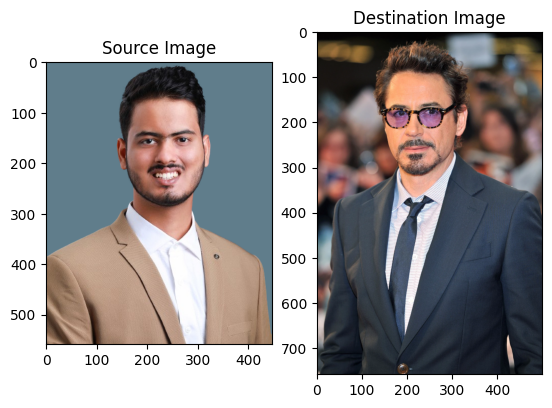

In [4]:
srcImg=cv2.imread(SOURCE_IMAGE)
destImg=cv2.imread(DESTINATION_IMAGE)

displayImgs(srcImg,destImg,title=["Source Image", "Destination Image"])

### Image Preprocessing
Before we process the images, we must ensure that both the source image and destination image are of the same size.
We resize the source image based on the dimentions of the destination image

In [5]:
def preprocessing(srcI,destI):
    image=cv2.resize(srcI,destI.shape[:2][::-1])
    cv2.imwrite(PREPROCESSED_SOURCE_IMAGE,image)
    return image

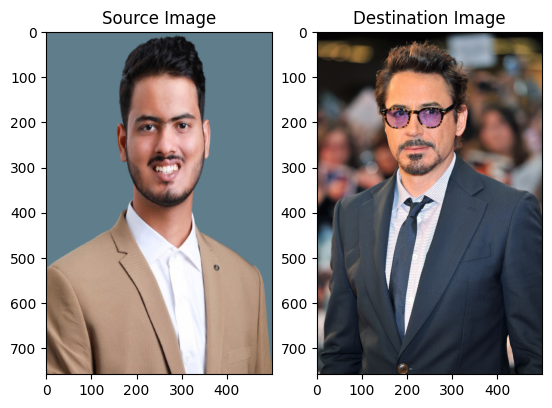

In [6]:
srcImg=preprocessing(srcImg,destImg)
displayImgs(srcImg,destImg,title=["Source Image", "Destination Image"])

### Landmark Detection

In [7]:
def getLandmarkDetections(srcI,destI):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(SHAPE_PREDICTOR)
    
    grayS = cv2.cvtColor(srcI, cv2.COLOR_BGR2GRAY)
    rectS = detector(grayS, 1)
    
    grayD = cv2.cvtColor(destI, cv2.COLOR_BGR2GRAY)
    rectD = detector(grayD, 1)
    
    pointsS = getLandmarkPoints(grayS,rectS,predictor)
    pointsD = getLandmarkPoints(grayD,rectD,predictor)
    return pointsS,pointsD

def getLandmarkPoints(img,rects,predictor):
    points=[]
    for (i, rect) in enumerate(rects):
        shape = predictor(img, rect)
        shape = face_utils.shape_to_np(shape)
        points.append(shape)
    return points

def getOverlay(img,points):
    image=img.copy()
    for (i, shape) in enumerate(points):
        for (x, y) in shape:
            image=cv2.circle(image, (x, y), 5, (0, 0, 255), -1)
    return image

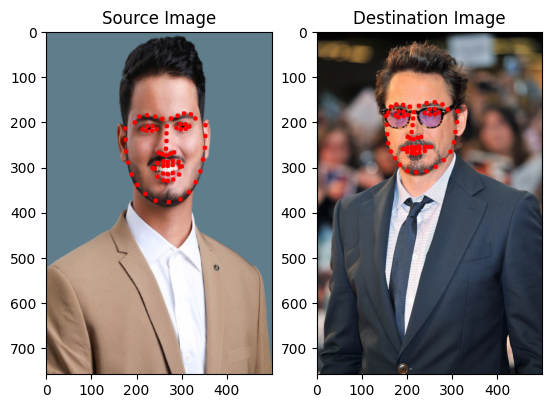

In [8]:
pointsS,pointsD=getLandmarkDetections(srcImg,destImg)
displayImgs(getOverlay(srcImg,pointsS),getOverlay(destImg,pointsD),title=["Source Image", "Destination Image"])
# print(pointsS[0])

### Add additional Points along the border

In [14]:
def mouse_click_coordinates(srcImg,destImg,pointsS,pointsD):
    SI=srcImg.copy()
    DI=destImg.copy()
    source_click_coordinates = []
    dest_click_coordinates = []
    def mouse_click_source(event, x, y, flags, param):

        if event == cv2.EVENT_LBUTTONDOWN:
            source_click_coordinates.append((x, y))
            print(f"Clicked at ({x}, {y})")
            
    def mouse_click_dest(event, x, y, flags, param):

        if event == cv2.EVENT_LBUTTONDOWN:
            dest_click_coordinates.append((x, y))
            print(f"Clicked at ({x}, {y})")

    cv2.namedWindow("Source Image")
    cv2.setMouseCallback("Source Image", mouse_click_source)
    
    cv2.namedWindow("Destination Image")
    cv2.setMouseCallback("Destination Image", mouse_click_dest)

    while True:
        if source_click_coordinates:
            source_last_coordinate=source_click_coordinates[-1]
            SI=cv2.circle(SI, source_last_coordinate, 5, (0, 0, 255), -1)
        if dest_click_coordinates:
            dest_last_coordinate=dest_click_coordinates[-1]
            DI=cv2.circle(DI, dest_last_coordinate, 5, (0, 0, 255), -1)
        cv2.imshow("Source Image", SI)
        cv2.imshow("Destination Image", DI)
        key = cv2.waitKey(1) & 0xFF

        # Break the loop if 'q' key is pressed
        if key == ord('q'):
            break

    # Destroy the OpenCV windows
    cv2.destroyAllWindows()
    pointsS =[np.concatenate((pointsS[0], source_click_coordinates), axis=0)]
    pointsD =[np.concatenate((pointsD[0], dest_click_coordinates), axis=0)]

    return pointsS,pointsD

    
pointsS,pointsD = mouse_click_coordinates(srcImg,destImg,pointsS,pointsD)

Clicked at (453, 428)
Clicked at (374, 366)
Clicked at (506, 359)
Clicked at (604, 419)


In [9]:
def addBorderPoints(pointsList,imageShape, n):
    
    points=pointsList.copy()
    width, height = imageShape[:2][::-1]

    # Calculate the step size to evenly distribute n points along each side
    step_size_x = width // (n // 4)
    step_size_y = height // (n // 4)

    # Generate points along the top border
    top_border = [(x, 0) for x in range(0, width, step_size_x)]

    # Generate points along the right border (excluding the top-right corner)
    right_border = [(width - 1, y) for y in range(0, height - step_size_y, step_size_y)]

    # Generate points along the bottom border (excluding the bottom-right corner)
    bottom_border = [(x, height - 1) for x in range(width - step_size_x, 0, -step_size_x)]

    # Generate points along the left border (excluding the bottom-left corner and top-left corner)
    left_border = [(0, y) for y in range(height - step_size_y, step_size_y, -step_size_y)]

    # Combine all borders and ensure the result has exactly n points
    result = list(set(top_border + right_border + bottom_border + left_border[:n - len(top_border) - len(right_border) - len(bottom_border)]))
    
    # print(result)
    points =[np.concatenate((points[0], result), axis=0)]
    
    return points
    
if NO_BORDER_POINTS:    
    pointsS=addBorderPoints(pointsS,srcImg.shape,NO_BORDER_POINTS)
    pointsD=addBorderPoints(pointsD,srcImg.shape,NO_BORDER_POINTS)

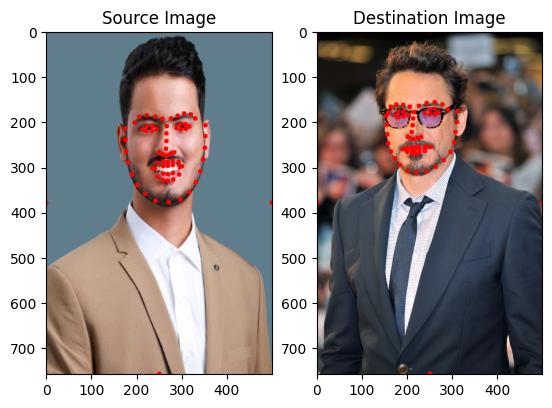

In [10]:
displayImgs(getOverlay(srcImg,pointsS),getOverlay(destImg,pointsD),title=["Source Image", "Destination Image"])

In [11]:
### Write the points to a file
def writePoints(fileNames,pointsS,pointsD):
    ps=pointsS[0]
    pd=pointsD[0]
    with open(fileNames[0], 'w+') as fp:
        for point in ps:
            fp.write(f"{point[0]}, {point[1]}\n")
    with open(fileNames[1], 'w+') as fp:
        for point in pd:
            fp.write(f"{point[0]}, {point[1]}\n")
            
writePoints([SOURCE_POINTS,DESTINATION_POINTS],pointsS,pointsD)

# *RUN FROM HERE*

## Initialisation and Loading landmarks

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

%matplotlib inline

In [13]:
# Helper function to display images
def displayImgs(srcI,destI,title=[]):
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(srcI,cv2.COLOR_BGR2RGB))
    if title:
        plt.title(title[0])
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(destI,cv2.COLOR_BGR2RGB))
    if title:
        plt.title(title[1])

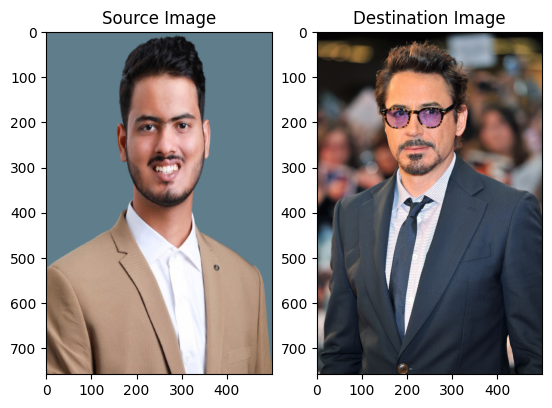

In [14]:
srcImg=cv2.imread(PREPROCESSED_SOURCE_IMAGE)
destImg=cv2.imread(DESTINATION_IMAGE)

displayImgs(srcImg,destImg,title=["Source Image", "Destination Image"])

In [15]:
def load_points(fileNames):
    ps=[]
    pd=[]
    with open(fileNames[0], 'r') as fp:
        for line in fp:
            x, y = map(int, line.strip().split(','))
            ps.append((x,y))
    
    with open(fileNames[1], 'r') as fp:
        for line in fp:
            x, y = map(int, line.strip().split(','))
            pd.append((x,y))
    return [np.array(ps)],[np.array(pd)]
        
pointsS,pointsD=load_points([SOURCE_POINTS,DESTINATION_POINTS])

### Delaunay Triangulation

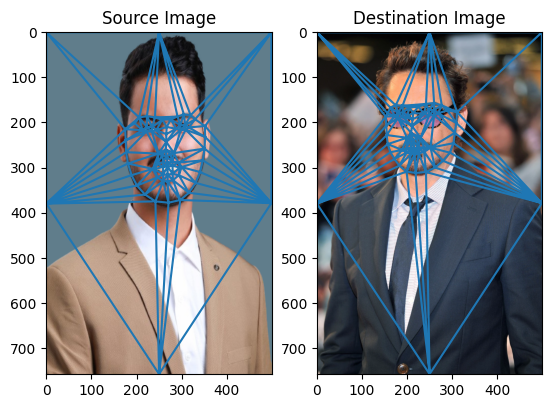

In [16]:
# Plot Delaunay triangles using Matplotlib
def plotTriangulation(imageS,pointsS,imageD,pointsD):
    pointsS=pointsS[0]
    pointsD=pointsD[0]
    
    triS = Delaunay(pointsS)
    triD = Delaunay(pointsD)
    
    plt.subplot(1, 2, 1)
    plt.triplot(pointsS[:,0], pointsS[:,1], triS.simplices)
    plt.imshow(cv2.cvtColor(imageS,cv2.COLOR_BGR2RGB))
    
    plt.title('Source Image')
    plt.subplot(1, 2, 2)
    plt.triplot(pointsD[:,0], pointsD[:,1], triD.simplices)
    plt.imshow(cv2.cvtColor(imageD,cv2.COLOR_BGR2RGB))
    plt.title('Destination Image')
    


def triangulate(points):
    # points=points
    tri = Delaunay(points)
    
    return tri.simplices

# Plot Delaunay triangles using OpenCV
def draw_delaunay(imgShape, triangleCoordinates):
    img=np.zeros(imgShape,dtype=np.uint8)

    for t in triangleCoordinates:
        # print(t)
        # pt1 = t[0]
        # pt2 = t[1]
        # pt3 = t[2]
        
        pt1 = (int(t[0][0]),int(t[0][1]))
        pt2 = (int(t[1][0]),int(t[1][1]))
        pt3 = (int(t[2][0]),int(t[2][1]))

        cv2.line(img, pt1, pt2, 255, 1, cv2.LINE_AA, 0)
        cv2.line(img, pt2, pt3, 255, 1, cv2.LINE_AA, 0)
        cv2.line(img, pt3, pt1, 255, 1, cv2.LINE_AA, 0)
    return img

def getTriangleCoordinates(ps,tri):
    triPoints=ps[tri]
    triPointsX=triPoints[:,:,0]
    triPointsY=triPoints[:,:,1]
    coordinates =[[(triPointsX[i][0],triPointsY[i][0]),(triPointsX[i][1],triPointsY[i][1]),(triPointsX[i][2],triPointsY[i][2])] for i in range(len(triPoints))]
    return coordinates

plotTriangulation(srcImg,pointsS,destImg,pointsD)

### Get intermediate points

In [17]:
def getEquidistantPoints(p1, p2, parts):
    return np.linspace(p1, p2, parts+1)

def getInterImgCoordinates(pointsS,pointsD):
    interPoints=[ [] for _ in range(NUM_IMAGES) ]

    for i in range(len(pointsS)):
        pS=pointsS[i]
        pD=pointsD[i]
        # print('Points S&D:',pS,pD)
        equidiatantPoints=getEquidistantPoints(pS,pD,NUM_IMAGES)
        # print(equidiatantPoints)
        for i in range(NUM_IMAGES):
            interPoints[i].append(equidiatantPoints[i])
        # interPoints[i].append(equidiatantPoints)
    for i in range(len(interPoints)):
        interPoints[i]=np.array(interPoints[i])
    return interPoints

interPoints=getInterImgCoordinates(pointsS[0],pointsD[0])

### Visualise the image transition using Delaunay triangles

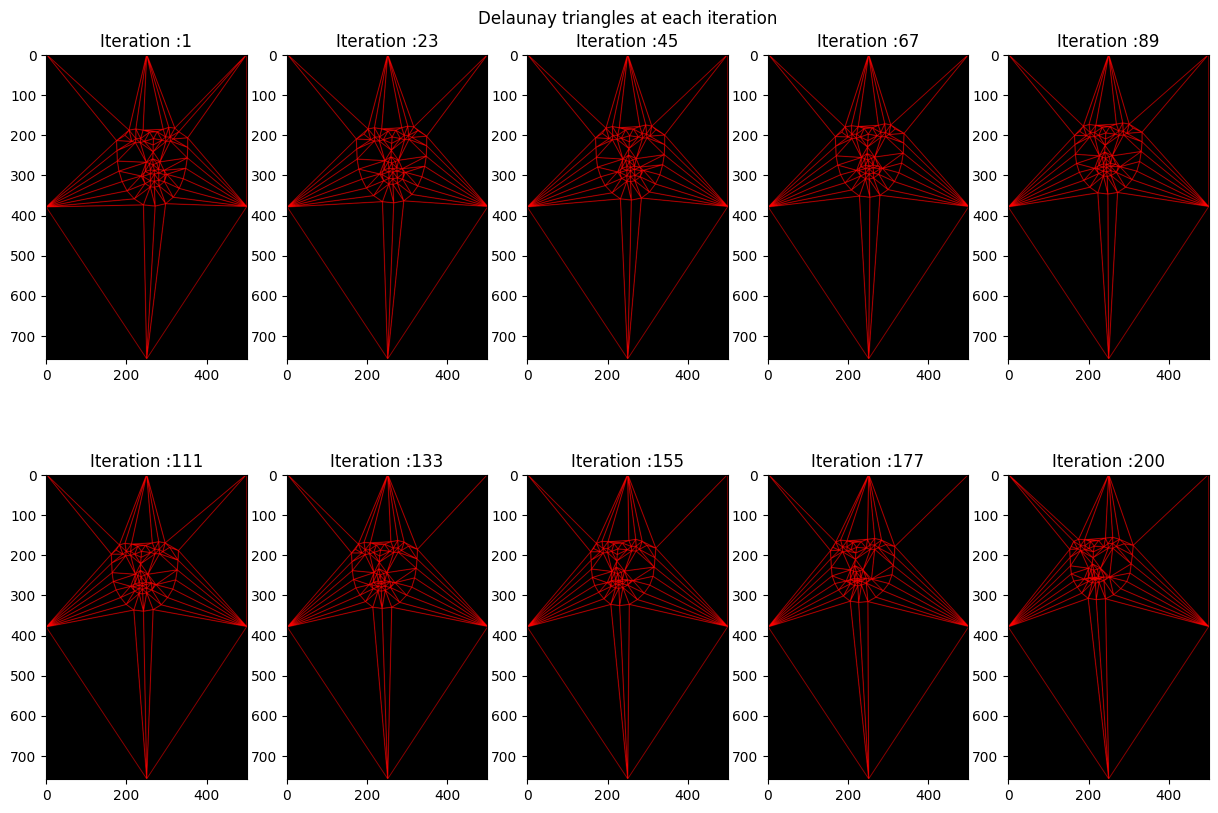

In [18]:
DISP_IMGS=10

delaunay_images=[]
for i in range(len(interPoints)):
    tri=triangulate(interPoints[i])
    # print(tri)
    triCoordinates=getTriangleCoordinates(interPoints[i],tri)
    img=draw_delaunay(destImg.shape,triCoordinates)
    delaunay_images.append(img)
    cv2.imshow('Delaunay Transition',img)
    k=cv2.waitKey(50)
cv2.destroyAllWindows()


indexes=list(np.linspace(0,len(delaunay_images)-1,DISP_IMGS).astype(int))
plt.figure(figsize=(15,10)) # specifying the overall grid size
plt.title('Delaunay triangles at each iteration')
plt.axis('off')
for i in range(DISP_IMGS):
    plt.subplot(2,5,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(delaunay_images[indexes[i]].astype(np.uint8))
    plt.title('Iteration :'+str(indexes[i]+1))

plt.show()


### Obtain Affine Transformation Matrix

In [19]:
def getAffineTransform(src, dst):
    src = np.hstack([src, np.ones((3, 1))])
    dst = np.hstack([dst, np.ones((3, 1))])

    src_inv = np.linalg.pinv(src)

    M = np.dot(src_inv, dst)

    M = M.T

    return M

#test the function using sample test case
src_points = np.float32([[0, 0], [10, 0], [0, 1]])
dst_points = np.float32([[1, 2], [3, 1], [2, 5]])
affine_matrix = getAffineTransform(src_points, dst_points)
print('Own Function')
print(affine_matrix)
print('cv2 function')
print(cv2.getAffineTransform(src_points,dst_points) )

Own Function
[[ 2.00000000e-01  1.00000000e+00  1.00000000e+00]
 [-1.00000000e-01  3.00000000e+00  2.00000000e+00]
 [ 5.63150704e-17 -3.33066907e-16  1.00000000e+00]]
cv2 function
[[ 0.2  1.   1. ]
 [-0.1  3.   2. ]]


In [20]:
a=src_points.T @ affine_matrix
print(a)

[[-1.00000000e+00  3.00000000e+01  2.00000000e+01]
 [ 5.63150704e-17 -3.33066907e-16  1.00000000e+00]]


### Apply Affine wrap using Inverse Wrap and Bilinear Interpolation

In [21]:
def warp_affine(image, M, output_shape):

    input_shape = image.shape

    output_grid_y, output_grid_x = np.mgrid[0:output_shape[0], 0:output_shape[1]]
    output_coords = np.vstack((output_grid_x.ravel(), output_grid_y.ravel(), np.ones_like(output_grid_x.ravel())))

    input_coords = np.linalg.pinv(M) @ output_coords

    input_coords /= input_coords[2, :]

    input_coords[0, :] = np.clip(input_coords[0, :], 0, input_shape[1] - 1)
    input_coords[1, :] = np.clip(input_coords[1, :], 0, input_shape[0] - 1)

    x_int, y_int = np.floor(input_coords[0, :]).astype(int), np.floor(input_coords[1, :]).astype(int)
    x_frac, y_frac = input_coords[0, :] - x_int, input_coords[1, :] - y_int
    
    x_int = np.clip(x_int, 0, input_shape[1] - 2)
    y_int = np.clip(y_int, 0, input_shape[0] - 2)
    
    w1 = (1 - x_frac) * (1 - y_frac)
    w2 = x_frac * (1 - y_frac)
    w3 = (1 - x_frac) * y_frac
    w4 = x_frac * y_frac
    
    
    I1 = image[y_int, x_int, :]
    I2 = image[y_int, x_int + 1, :]
    I3 = image[y_int + 1, x_int, :]
    I4 = image[y_int + 1, x_int + 1, :]
    
    result = (w1[:, np.newaxis] * I1) + (w2[:, np.newaxis] * I2) + (w3[:, np.newaxis] * I3) + (w4[:, np.newaxis] * I4)
    result = result.reshape((output_shape[0], output_shape[1], 3))

    return result.astype(np.uint8)


image = srcImg.copy()

result = warp_affine(image, affine_matrix, image.shape)


In [22]:
def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

def rearrange_vertices(v1, v2):
    # Calculate distances between each pair of vertices in v1 and v2
    distances = np.array([[euclidean_distance(v1[i], v2[j]) for j in range(3)] for i in range(3)])

    # Find the indices that would sort each row in distances
    sorted_indices = np.argsort(distances, axis=1)

    # Rearrange v2 based on the sorted indices
    rearranged_v2 = np.array([v2[i] for i in sorted_indices[:, 0]])

    return rearranged_v2

def point_inside_triangle(point, triangle_vertices):
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

    d1 = sign(point, triangle_vertices[0], triangle_vertices[1])
    d2 = sign(point, triangle_vertices[1], triangle_vertices[2])
    d3 = sign(point, triangle_vertices[2], triangle_vertices[0])

    has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0)
    has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0)

    return not (has_neg and has_pos)

def triangle_area(vertices):
    import numpy as np
    return 0.5 * np.abs(np.cross(vertices[1] - vertices[0], vertices[2] - vertices[0]))

def find_corresponding_triangles(triangulation1, triangulation2):
    corresponding_vertex_pairs = []
    area_threshold = 0.01

    for simplex1 in triangulation1.simplices:
        barycenter1 = np.mean(triangulation1.points[simplex1], axis=0)

        closest_triangle2 = None
        min_distance = float('inf')

        for i, simplex2 in enumerate(triangulation2.simplices):
            barycenter2 = np.mean(triangulation2.points[simplex2], axis=0)

            distance = np.sqrt(np.sum(np.square(barycenter2 - barycenter1)))

            if point_inside_triangle(barycenter1, triangulation2.points[simplex2]):
                area1 = triangle_area(triangulation1.points[simplex1])
                area2 = triangle_area(triangulation2.points[simplex2])

                if np.abs(area1 - area2) / max(area1, area2) < area_threshold:
                    vertices1 = triangulation1.points[simplex1]
                    vertices2 = triangulation2.points[simplex2]

                    if distance < min_distance:
                        min_distance = distance
                        closest_triangle2 = vertices2

        if closest_triangle2 is not None:
            vertices2 = rearrange_vertices(vertices1, closest_triangle2)
            corresponding_vertex_pairs.append((vertices1, vertices2))

    return corresponding_vertex_pairs

def imgOverlay(img1,img2):
    
    cv2.imshow('Triangle',img2)
    cv2.waitKey(1)
    mask = np.all(img2 != [255, 255, 255], axis=-1)
    outImg = np.where(mask[:, :, None], img2, img1)

    return outImg
    
def drawTriangle(image,t,color):
    img=image.copy()
    pt1 = (int(t[0][0]),int(t[0][1]))
    pt2 = (int(t[1][0]),int(t[1][1]))
    pt3 = (int(t[2][0]),int(t[2][1]))
    if color=='blue':
        c=(255,0,0)
        thickness=2
    else:
        c=(0,0,255)
        thickness=1

    cv2.line(img, pt1, pt2, c, thickness, cv2.LINE_AA, 0)
    cv2.line(img, pt2, pt3, c, thickness, cv2.LINE_AA, 0)
    cv2.line(img, pt3, pt1, c, thickness, cv2.LINE_AA, 0)
    return img

def applyAffineWrapTriangle(img1,triPoints1,triPoints2):
    
    img2 = 255 * np.ones(img1.shape, dtype = img1.dtype)
    tri1 = np.float32([triPoints1])
    tri2 = np.float32([triPoints2])
    # print(tri1,tri2)
    
    r1 = cv2.boundingRect(tri1)
    r2 = cv2.boundingRect(tri2)
    
    tri1Cropped = []
    tri2Cropped = []
    
    for i in range(0, 3):
        tri1Cropped.append(((tri1[0][i][0] - r1[0]),(tri1[0][i][1] - r1[1])))
        tri2Cropped.append(((tri2[0][i][0] - r2[0]),(tri2[0][i][1] - r2[1])))

    img1Cropped = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    
    warpMat = cv2.getAffineTransform( np.float32(tri1Cropped), np.float32(tri2Cropped) )
    img2Cropped=cv2.warpAffine( img1Cropped, warpMat, (r2[2], r2[3]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )
    
    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(tri2Cropped), (1.0, 1.0, 1.0), 16, 0);

    img2Cropped = img2Cropped * mask

    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )

    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Cropped

    out = imgOverlay(img1,img2)
    triImg=drawTriangle(out,tri1[0],'blue')
    triImg=drawTriangle(triImg,tri2[0],'red')
    cv2.imshow('triangle',triImg)
    return out


def applyAffineTransformation(image,interPoints):
    images=[]

    for i in range(len(interPoints)-1):
        
        tri1=Delaunay(interPoints[i])
        tri2=Delaunay(interPoints[i+1])

        correspondingTriangles= find_corresponding_triangles(tri1, tri2)
        # print(correspondingTriangles)
        for triangle in range(len(correspondingTriangles)):

            triPoints1= correspondingTriangles[triangle][0]
            triPoints2= correspondingTriangles[triangle][1]

            image=applyAffineWrapTriangle(image,triPoints1,triPoints2)
            disp=image.copy()
            disp = cv2.putText(disp, 'Image: '+str(i)+' / '+str(len(interPoints)), (10,50), cv2.FONT_HERSHEY_SIMPLEX ,  
                   1, (255, 0, 0) , 2, cv2.LINE_AA) 
            
            cv2.imshow('AffineWrap',disp)
            k=cv2.waitKey(1)
            if k==ord('q'):
                return
            elif k==ord('i'):
                cv2.waitKey(0)
        images.append(image)
    cv2.imshow('AffineWrap',image)
    # cv2.waitKey(0)
    cv2.destroyAllWindows()
    return images

In [23]:
imagesSource=applyAffineTransformation(srcImg,interPoints)
cv2.destroyAllWindows()

In [24]:
reverseTransitionInterPoints=interPoints[::-1][:NUM_IMAGES//2]
imagesDest=applyAffineTransformation(destImg,reverseTransitionInterPoints)
cv2.destroyAllWindows()

### Apply Transition and Save as Video

In [25]:
def applyTransition(imagesSource,imagesDest):
    transitionImages=[]
    w=np.linspace(0,1,len(imagesSource))
    for i in range(len(imagesSource)):
        if i <(len(imagesSource)//2):
            outImg=cv2.addWeighted(imagesSource[i], 1-w[i], imagesDest[i], w[i], 0.0)
        else:
            if -(i-len(imagesSource)//2):
                outImg=cv2.addWeighted(imagesSource[i], 1-w[i], imagesDest[-(i-len(imagesSource)//2)], w[i], 0.0)    
                
        transitionImages.append(outImg)
        cv2.imshow('Transition',outImg)
        cv2.waitKey(50)
    cv2.destroyAllWindows()
    return transitionImages
transitionImages=applyTransition(imagesSource,imagesDest)

In [26]:
def images_to_video(image_list, video_name, fps=30):

    height, width, layers = image_list[0].shape

    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in image_list:
        video.write(image)

    cv2.destroyAllWindows()
    video.release()

images_to_video(transitionImages, VIDEO_NAME,fps=FPS)